In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [5]:
df = pd.read_csv("C:\\Users\\Kesi2\\OneDrive\\Desktop\\FDM\\waqi_global_dataset_with_categoricals.csv")

print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (12815, 20)
     uid                 time    aqi            city_name        lat  \
0    428  2025-09-21 01:00:00  107.0        Osorno, Chile -40.584479   
1   8821  2025-09-21 01:00:00   63.0       Mirasol, Chile -41.479507   
2  14756  2025-09-21 02:00:00   46.0  Puerto Varas, Chile -41.328935   
3    445  2025-09-21 02:00:00  152.0     Coyhaique, Chile -45.579964   
4  10699  2025-09-21 01:00:00   38.0      Vialidad, Chile -45.406800   

         lon   pm25  pm10  no2  so2  co  o3  temp_c  humidity_pct  \
0 -73.118720  107.0  37.0  NaN  NaN NaN NaN     8.7          93.8   
1 -72.968756   63.0   NaN  NaN  NaN NaN NaN     8.0          93.0   
2 -72.968209   46.0  12.0  NaN  NaN NaN NaN     8.0          93.0   
3 -72.061126  152.0  46.0  NaN  NaN NaN NaN     6.0          87.0   
4 -72.696260   38.0   NaN  NaN  NaN NaN NaN     6.0          93.0   

   pressure_hpa  wind_speed_mps             aqi_category  month  season  \
0        1008.3             0.9  Unhealthy for Sen

In [6]:
target = "aqi_category"

In [7]:
# Candidate features from WAQI dataset
num_features = ["pm25","pm10","no2","so2","co","o3",
                "temp_c","humidity_pct","pressure_hpa","wind_speed_mps"]

cat_features = ["season","temp_condition"]



In [8]:
# Keep only available
num_features = [c for c in num_features if c in df.columns]
cat_features = [c for c in cat_features if c in df.columns]

X = df[num_features + cat_features]
y = df[target]

print("Numeric Features:", num_features)
print("Categorical Features:", cat_features)

Numeric Features: ['pm25', 'pm10', 'no2', 'so2', 'co', 'o3', 'temp_c', 'humidity_pct', 'pressure_hpa', 'wind_speed_mps']
Categorical Features: ['season', 'temp_condition']


In [9]:
# Numeric → fill with mean
for c in num_features:
    X[c] = pd.to_numeric(X[c], errors="coerce")
    X[c] = X[c].fillna(X[c].mean())

# Categorical → fill with mode
for c in cat_features:
    X[c] = X[c].fillna(X[c].mode()[0])

# Drop rows where target is missing
X = X[y.notna()]
y = y[y.notna()]




C:\Users\Kesi2\AppData\Local\Temp\ipykernel_20860\807754761.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[c] = pd.to_numeric(X[c], errors="coerce")
C:\Users\Kesi2\AppData\Local\Temp\ipykernel_20860\807754761.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[c] = X[c].fillna(X[c].mean())
C:\Users\Kesi2\AppData\Local\Temp\ipykernel_20860\807754761.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [10]:
# Encode categorical features (label encoding for simplicity)
for c in cat_features:
    le = LabelEncoder()
    X[c] = le.fit_transform(X[c])

# Encode target
y_le = LabelEncoder().fit_transform(y)

In [11]:
scaler = StandardScaler()
X[num_features] = scaler.fit_transform(X[num_features])

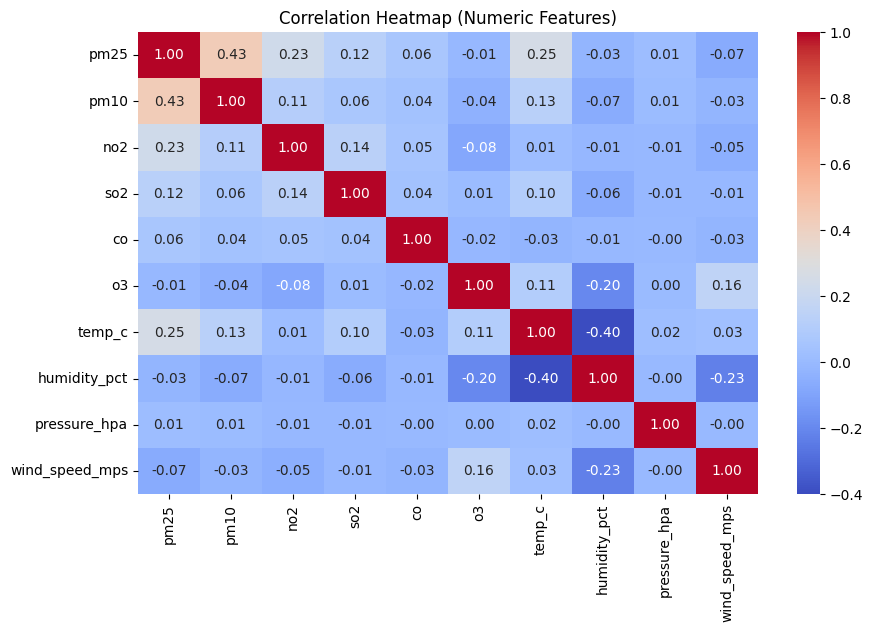

In [12]:
plt.figure(figsize=(10,6))
sns.heatmap(X[num_features].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

In [13]:
# Random Forest (Bagging)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y_le)
rf_importances = pd.Series(rf.feature_importances_, index=X.columns)

# Gradient Boosting (Boosting)
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X, y_le)
gb_importances = pd.Series(gb.feature_importances_, index=X.columns)

# Aggregate importances
feature_importance = pd.DataFrame({
    "RandomForest": rf_importances,
    "GradientBoosting": gb_importances
})
feature_importance["Mean"] = feature_importance.mean(axis=1)
feature_importance = feature_importance.sort_values("Mean", ascending=False)

print("\n=== Feature Importance (Bagging + Boosting Aggregated) ===")
print(feature_importance)


=== Feature Importance (Bagging + Boosting Aggregated) ===
                RandomForest  GradientBoosting      Mean
pm25                0.621934          0.879220  0.750577
pm10                0.169209          0.060375  0.114792
o3                  0.033309          0.023594  0.028451
co                  0.029694          0.006687  0.018190
no2                 0.030108          0.006169  0.018139
pressure_hpa        0.026132          0.003939  0.015035
so2                 0.024806          0.005186  0.014996
humidity_pct        0.021542          0.006613  0.014078
temp_c              0.022772          0.003466  0.013119
wind_speed_mps      0.016930          0.004486  0.010708
temp_condition      0.003485          0.000263  0.001874
season              0.000079          0.000000  0.000039


In [14]:
top_features = feature_importance.index[:8].tolist()
print("\nSelected Best Features:", top_features)

# Final processed dataset
X_selected = X[top_features]


Selected Best Features: ['pm25', 'pm10', 'o3', 'co', 'no2', 'pressure_hpa', 'so2', 'humidity_pct']



=== Logistic Regression ===
Accuracy: 0.9462
                         precision    recall  f1-score   support

                   Good       0.97      0.98      0.98      2023
              Hazardous       0.00      0.00      0.00         4
               Moderate       0.88      0.90      0.89       450
              Unhealthy       0.43      0.20      0.27        15
Unhealthy for Sensitive       0.64      0.57      0.61        47
                Unknown       0.00      0.00      0.00        23
         Very Unhealthy       0.00      0.00      0.00         1

               accuracy                           0.95      2563
              macro avg       0.42      0.38      0.39      2563
           weighted avg       0.93      0.95      0.94      2563



c:\Users\Kesi2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Kesi2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Kesi2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

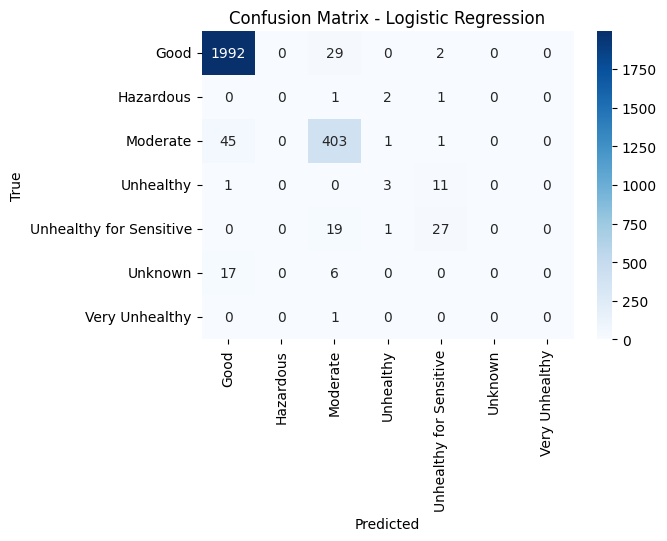


=== Random Forest  ===
Accuracy: 0.9789
                         precision    recall  f1-score   support

                   Good       0.99      0.99      0.99      2023
              Hazardous       0.00      0.00      0.00         4
               Moderate       0.94      0.98      0.96       450
              Unhealthy       0.87      0.87      0.87        15
Unhealthy for Sensitive       0.94      1.00      0.97        47
                Unknown       1.00      0.13      0.23        23
         Very Unhealthy       0.00      0.00      0.00         1

               accuracy                           0.98      2563
              macro avg       0.68      0.57      0.57      2563
           weighted avg       0.98      0.98      0.98      2563



c:\Users\Kesi2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Kesi2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Kesi2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

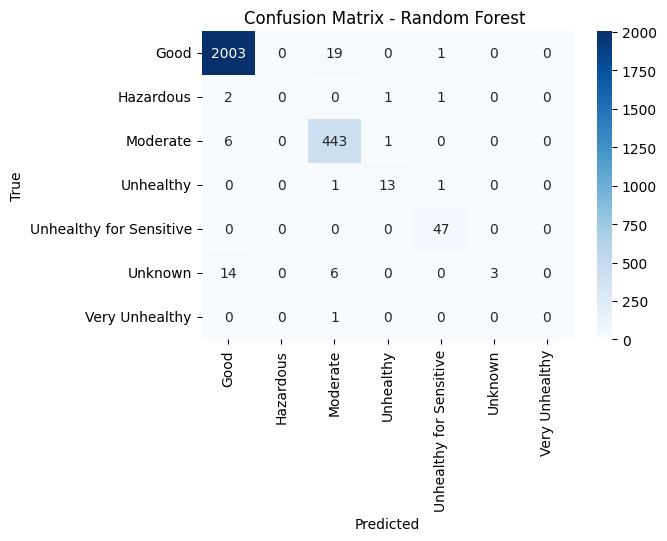


=== Gradient Boosting  ===
Accuracy: 0.977
                         precision    recall  f1-score   support

                   Good       0.99      0.99      0.99      2023
              Hazardous       0.67      0.50      0.57         4
               Moderate       0.94      0.98      0.96       450
              Unhealthy       1.00      0.93      0.97        15
Unhealthy for Sensitive       0.94      1.00      0.97        47
                Unknown       0.33      0.13      0.19        23
         Very Unhealthy       0.00      0.00      0.00         1

               accuracy                           0.98      2563
              macro avg       0.70      0.65      0.66      2563
           weighted avg       0.97      0.98      0.97      2563



c:\Users\Kesi2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Kesi2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Kesi2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

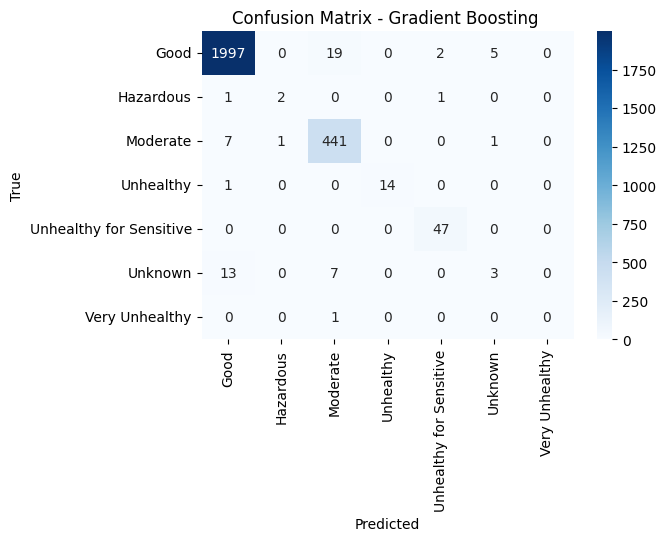

In [21]:
target = "aqi_category"
features = ["pm25","pm10","no2","so2","co","o3","pressure_hpa","humidity_pct"]
features = [f for f in features if f in df.columns]

X = df[features].copy()
y = df[target]

# Drop rows with missing target
X = X[y.notna()]
y = y[y.notna()]

# Force all features numeric (turns text "NaN" into np.nan)
X = X.apply(pd.to_numeric, errors="coerce")


le = LabelEncoder()
y_enc = le.fit_transform(y)


X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="mean")),   # fill NaNs with mean
            ("scaler", StandardScaler())
        ]), features)
    ]
)


def train_and_evaluate(model, model_name):
    clf = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"\n=== {model_name} ===")
    print("Accuracy:", round(acc, 4))
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_,
                yticklabels=le.classes_)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


train_and_evaluate(LogisticRegression(max_iter=1000), "Logistic Regression")
train_and_evaluate(RandomForestClassifier(n_estimators=200, random_state=42), "Random Forest ")
train_and_evaluate(GradientBoostingClassifier(random_state=42), "Gradient Boosting ")

In [22]:
import joblib

# retrain final model on training set using the pipeline
final_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

final_model.fit(X_train, y_train)

# save pipeline + label encoder
joblib.dump(final_model, "aqi_predictor_with_pm.pkl")
joblib.dump(le, "label_encoder.pkl")

print("✅ Model & encoder saved successfully!")


✅ Model & encoder saved successfully!
